In [1]:
import sys
sys.path.append('..')
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [41]:
from src.nf import NormalizingFlowModel, MAF, CalibratedModel, neg_log_likelihood
from src.nf.classifiers import train_catboost_clf, make_clf_dataset
from utils import data_utils

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import MultivariateNormal
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

from copy import deepcopy

import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

In [3]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
! nvidia-smi

Sat Apr 11 08:46:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 0000666E:00:00.0 Off |                    0 |
| N/A   52C    P0    72W / 149W |  10965MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           On   | 0000A3CE:00:00.0 Off |                    0 |
| N/A   69C    P0    58W / 149W |   4685MiB / 11441MiB |     10%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [6]:
data = data_utils.GAS()

In [7]:
dim = data.n_dims

In [8]:
data.trn.x.shape

(852174, 8)

In [9]:
X_train_tensor = torch.from_numpy(data.trn.x).to(device)
X_test_tensor = torch.from_numpy(data.tst.x).to(device)

In [10]:
prior = MultivariateNormal(torch.zeros(dim).to(device), torch.eye(dim).to(device))
model = NormalizingFlowModel(dim, prior, [MAF(dim, 32), MAF(dim, 32), MAF(dim, 32), MAF(dim, 32)]).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [53]:
epoches = 10000
plot_freq = 10
metrics_train, metrics_test = [], []

Train log likelihood: 8.288336658477784
Test log likelihood: 8.2859468460083


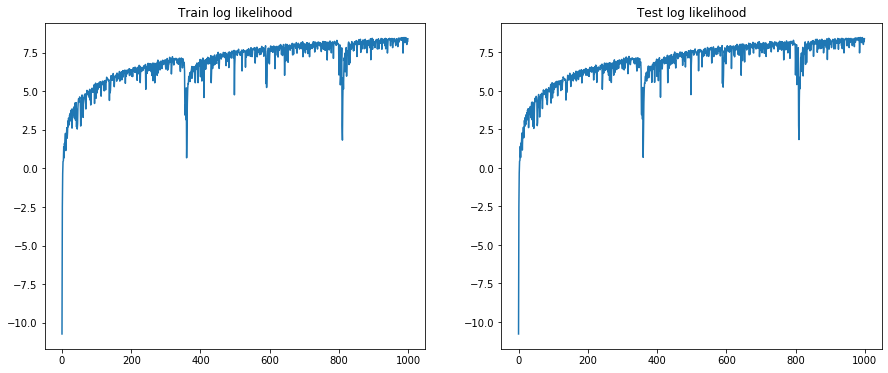

In [54]:
for epoch in range(len(metrics_train) * plot_freq, epoches):
    loss = model.ll_train_step(optimizer, X_train_tensor)

    if epoch % plot_freq == 0:
        metrics_train.append(-neg_log_likelihood(model, X_train_tensor))
        metrics_test.append(-neg_log_likelihood(model, X_test_tensor))
        
        clear_output(False)
        fig, axs = plt.subplots(1, 2, figsize=(15, 6))

        print(f'Train log likelihood: {np.mean(metrics_train[-10:])}')
        print(f'Test log likelihood: {np.mean(metrics_test[-10:])}')
        axs[0].plot(np.arange(len(metrics_train)), metrics_train)
        axs[0].set_title('Train log likelihood')
        axs[1].plot(np.arange(len(metrics_test)), metrics_test)
        axs[1].set_title('Test log likelihood')

    plt.show()

In [55]:
torch.save(model.state_dict(), './GAS/model')
torch.save(optimizer.state_dict(), './GAS/optimizer')

In [56]:
clf_ds_train = make_clf_dataset(X_train_tensor, model)
clf_ds_test = make_clf_dataset(X_test_tensor, model)

In [57]:
clf = CatBoostClassifier(
    1000, eval_metric='AUC',
    metric_period=1,
).fit(
    clf_ds_train[:, :-1], clf_ds_train[:, -1],
    eval_set=(clf_ds_test[:, :-1], clf_ds_test[:, -1])
)

Learning rate set to 0.199115
0:	test: 0.5823399	best: 0.5823399 (0)	total: 390ms	remaining: 6m 29s
1:	test: 0.5920071	best: 0.5920071 (1)	total: 598ms	remaining: 4m 58s
2:	test: 0.5929736	best: 0.5929736 (2)	total: 848ms	remaining: 4m 41s
3:	test: 0.5941415	best: 0.5941415 (3)	total: 1.2s	remaining: 4m 57s
4:	test: 0.5979058	best: 0.5979058 (4)	total: 1.56s	remaining: 5m 9s
5:	test: 0.6090519	best: 0.6090519 (5)	total: 1.81s	remaining: 4m 59s
6:	test: 0.6159058	best: 0.6159058 (6)	total: 2.06s	remaining: 4m 51s
7:	test: 0.6161156	best: 0.6161156 (7)	total: 2.39s	remaining: 4m 56s
8:	test: 0.6248989	best: 0.6248989 (8)	total: 2.78s	remaining: 5m 6s
9:	test: 0.6301205	best: 0.6301205 (9)	total: 3.11s	remaining: 5m 7s
10:	test: 0.6422212	best: 0.6422212 (10)	total: 3.5s	remaining: 5m 14s
11:	test: 0.6467053	best: 0.6467053 (11)	total: 3.88s	remaining: 5m 19s
12:	test: 0.6481514	best: 0.6481514 (12)	total: 4.36s	remaining: 5m 30s
13:	test: 0.6482602	best: 0.6482602 (13)	total: 4.69s	remai

114:	test: 0.7793506	best: 0.7793506 (114)	total: 45.6s	remaining: 5m 51s
115:	test: 0.7803738	best: 0.7803738 (115)	total: 46.3s	remaining: 5m 52s
116:	test: 0.7806781	best: 0.7806781 (116)	total: 46.7s	remaining: 5m 52s
117:	test: 0.7811970	best: 0.7811970 (117)	total: 47.2s	remaining: 5m 52s
118:	test: 0.7814161	best: 0.7814161 (118)	total: 47.6s	remaining: 5m 52s
119:	test: 0.7819855	best: 0.7819855 (119)	total: 48s	remaining: 5m 52s
120:	test: 0.7832363	best: 0.7832363 (120)	total: 48.6s	remaining: 5m 52s
121:	test: 0.7835568	best: 0.7835568 (121)	total: 48.9s	remaining: 5m 52s
122:	test: 0.7838754	best: 0.7838754 (122)	total: 49.2s	remaining: 5m 51s
123:	test: 0.7845904	best: 0.7845904 (123)	total: 49.6s	remaining: 5m 50s
124:	test: 0.7853615	best: 0.7853615 (124)	total: 50s	remaining: 5m 50s
125:	test: 0.7860393	best: 0.7860393 (125)	total: 50.3s	remaining: 5m 49s
126:	test: 0.7866420	best: 0.7866420 (126)	total: 50.8s	remaining: 5m 49s
127:	test: 0.7872200	best: 0.7872200 (127)

225:	test: 0.8222360	best: 0.8222360 (225)	total: 1m 35s	remaining: 5m 26s
226:	test: 0.8224522	best: 0.8224522 (226)	total: 1m 35s	remaining: 5m 26s
227:	test: 0.8227022	best: 0.8227022 (227)	total: 1m 36s	remaining: 5m 25s
228:	test: 0.8230093	best: 0.8230093 (228)	total: 1m 36s	remaining: 5m 25s
229:	test: 0.8231897	best: 0.8231897 (229)	total: 1m 37s	remaining: 5m 25s
230:	test: 0.8234395	best: 0.8234395 (230)	total: 1m 37s	remaining: 5m 25s
231:	test: 0.8237464	best: 0.8237464 (231)	total: 1m 38s	remaining: 5m 25s
232:	test: 0.8239221	best: 0.8239221 (232)	total: 1m 38s	remaining: 5m 24s
233:	test: 0.8241172	best: 0.8241172 (233)	total: 1m 39s	remaining: 5m 24s
234:	test: 0.8244616	best: 0.8244616 (234)	total: 1m 39s	remaining: 5m 24s
235:	test: 0.8246779	best: 0.8246779 (235)	total: 1m 39s	remaining: 5m 23s
236:	test: 0.8249316	best: 0.8249316 (236)	total: 1m 40s	remaining: 5m 23s
237:	test: 0.8251236	best: 0.8251236 (237)	total: 1m 40s	remaining: 5m 22s
238:	test: 0.8254586	best

336:	test: 0.8451837	best: 0.8451837 (336)	total: 2m 24s	remaining: 4m 43s
337:	test: 0.8453416	best: 0.8453416 (337)	total: 2m 24s	remaining: 4m 43s
338:	test: 0.8454565	best: 0.8454565 (338)	total: 2m 25s	remaining: 4m 42s
339:	test: 0.8455889	best: 0.8455889 (339)	total: 2m 25s	remaining: 4m 42s
340:	test: 0.8458862	best: 0.8458862 (340)	total: 2m 25s	remaining: 4m 42s
341:	test: 0.8460592	best: 0.8460592 (341)	total: 2m 26s	remaining: 4m 41s
342:	test: 0.8462076	best: 0.8462076 (342)	total: 2m 27s	remaining: 4m 41s
343:	test: 0.8463343	best: 0.8463343 (343)	total: 2m 27s	remaining: 4m 41s
344:	test: 0.8465667	best: 0.8465667 (344)	total: 2m 28s	remaining: 4m 41s
345:	test: 0.8467876	best: 0.8467876 (345)	total: 2m 28s	remaining: 4m 40s
346:	test: 0.8468940	best: 0.8468940 (346)	total: 2m 29s	remaining: 4m 40s
347:	test: 0.8471404	best: 0.8471404 (347)	total: 2m 29s	remaining: 4m 40s
348:	test: 0.8473823	best: 0.8473823 (348)	total: 2m 30s	remaining: 4m 39s
349:	test: 0.8474796	best

446:	test: 0.8601341	best: 0.8601341 (446)	total: 3m 12s	remaining: 3m 58s
447:	test: 0.8602889	best: 0.8602889 (447)	total: 3m 13s	remaining: 3m 57s
448:	test: 0.8604318	best: 0.8604318 (448)	total: 3m 13s	remaining: 3m 57s
449:	test: 0.8605526	best: 0.8605526 (449)	total: 3m 13s	remaining: 3m 56s
450:	test: 0.8606143	best: 0.8606143 (450)	total: 3m 14s	remaining: 3m 56s
451:	test: 0.8607139	best: 0.8607139 (451)	total: 3m 14s	remaining: 3m 56s
452:	test: 0.8608464	best: 0.8608464 (452)	total: 3m 15s	remaining: 3m 55s
453:	test: 0.8610139	best: 0.8610139 (453)	total: 3m 15s	remaining: 3m 55s
454:	test: 0.8611670	best: 0.8611670 (454)	total: 3m 16s	remaining: 3m 54s
455:	test: 0.8612733	best: 0.8612733 (455)	total: 3m 16s	remaining: 3m 54s
456:	test: 0.8613738	best: 0.8613738 (456)	total: 3m 16s	remaining: 3m 53s
457:	test: 0.8613930	best: 0.8613930 (457)	total: 3m 17s	remaining: 3m 53s
458:	test: 0.8614266	best: 0.8614266 (458)	total: 3m 17s	remaining: 3m 52s
459:	test: 0.8616108	best

556:	test: 0.8718270	best: 0.8718270 (556)	total: 4m 1s	remaining: 3m 12s
557:	test: 0.8719390	best: 0.8719390 (557)	total: 4m 2s	remaining: 3m 12s
558:	test: 0.8719651	best: 0.8719651 (558)	total: 4m 2s	remaining: 3m 11s
559:	test: 0.8720256	best: 0.8720256 (559)	total: 4m 3s	remaining: 3m 11s
560:	test: 0.8721221	best: 0.8721221 (560)	total: 4m 3s	remaining: 3m 10s
561:	test: 0.8722491	best: 0.8722491 (561)	total: 4m 4s	remaining: 3m 10s
562:	test: 0.8724095	best: 0.8724095 (562)	total: 4m 4s	remaining: 3m 9s
563:	test: 0.8724889	best: 0.8724889 (563)	total: 4m 5s	remaining: 3m 9s
564:	test: 0.8725529	best: 0.8725529 (564)	total: 4m 5s	remaining: 3m 9s
565:	test: 0.8726712	best: 0.8726712 (565)	total: 4m 5s	remaining: 3m 8s
566:	test: 0.8727751	best: 0.8727751 (566)	total: 4m 6s	remaining: 3m 8s
567:	test: 0.8728465	best: 0.8728465 (567)	total: 4m 6s	remaining: 3m 7s
568:	test: 0.8729044	best: 0.8729044 (568)	total: 4m 7s	remaining: 3m 7s
569:	test: 0.8729346	best: 0.8729346 (569)	to

666:	test: 0.8806466	best: 0.8806466 (666)	total: 4m 51s	remaining: 2m 25s
667:	test: 0.8807021	best: 0.8807021 (667)	total: 4m 52s	remaining: 2m 25s
668:	test: 0.8808434	best: 0.8808434 (668)	total: 4m 52s	remaining: 2m 24s
669:	test: 0.8809976	best: 0.8809976 (669)	total: 4m 52s	remaining: 2m 24s
670:	test: 0.8810946	best: 0.8810946 (670)	total: 4m 53s	remaining: 2m 23s
671:	test: 0.8811485	best: 0.8811485 (671)	total: 4m 53s	remaining: 2m 23s
672:	test: 0.8812461	best: 0.8812461 (672)	total: 4m 54s	remaining: 2m 23s
673:	test: 0.8813724	best: 0.8813724 (673)	total: 4m 54s	remaining: 2m 22s
674:	test: 0.8814418	best: 0.8814418 (674)	total: 4m 55s	remaining: 2m 22s
675:	test: 0.8814511	best: 0.8814511 (675)	total: 4m 55s	remaining: 2m 21s
676:	test: 0.8815442	best: 0.8815442 (676)	total: 4m 56s	remaining: 2m 21s
677:	test: 0.8816370	best: 0.8816370 (677)	total: 4m 56s	remaining: 2m 20s
678:	test: 0.8816820	best: 0.8816820 (678)	total: 4m 57s	remaining: 2m 20s
679:	test: 0.8817643	best

776:	test: 0.8880676	best: 0.8880676 (776)	total: 5m 39s	remaining: 1m 37s
777:	test: 0.8881524	best: 0.8881524 (777)	total: 5m 40s	remaining: 1m 37s
778:	test: 0.8881847	best: 0.8881847 (778)	total: 5m 40s	remaining: 1m 36s
779:	test: 0.8882447	best: 0.8882447 (779)	total: 5m 40s	remaining: 1m 36s
780:	test: 0.8883231	best: 0.8883231 (780)	total: 5m 41s	remaining: 1m 35s
781:	test: 0.8883612	best: 0.8883612 (781)	total: 5m 41s	remaining: 1m 35s
782:	test: 0.8884656	best: 0.8884656 (782)	total: 5m 42s	remaining: 1m 34s
783:	test: 0.8885149	best: 0.8885149 (783)	total: 5m 42s	remaining: 1m 34s
784:	test: 0.8885912	best: 0.8885912 (784)	total: 5m 43s	remaining: 1m 34s
785:	test: 0.8886588	best: 0.8886588 (785)	total: 5m 43s	remaining: 1m 33s
786:	test: 0.8887711	best: 0.8887711 (786)	total: 5m 44s	remaining: 1m 33s
787:	test: 0.8888367	best: 0.8888367 (787)	total: 5m 44s	remaining: 1m 32s
788:	test: 0.8889012	best: 0.8889012 (788)	total: 5m 45s	remaining: 1m 32s
789:	test: 0.8889984	best

887:	test: 0.8948829	best: 0.8948829 (887)	total: 6m 30s	remaining: 49.3s
888:	test: 0.8949030	best: 0.8949030 (888)	total: 6m 31s	remaining: 48.9s
889:	test: 0.8950349	best: 0.8950349 (889)	total: 6m 31s	remaining: 48.4s
890:	test: 0.8950816	best: 0.8950816 (890)	total: 6m 32s	remaining: 48s
891:	test: 0.8951229	best: 0.8951229 (891)	total: 6m 33s	remaining: 47.6s
892:	test: 0.8951412	best: 0.8951412 (892)	total: 6m 33s	remaining: 47.2s
893:	test: 0.8951947	best: 0.8951947 (893)	total: 6m 34s	remaining: 46.7s
894:	test: 0.8952530	best: 0.8952530 (894)	total: 6m 34s	remaining: 46.3s
895:	test: 0.8953102	best: 0.8953102 (895)	total: 6m 35s	remaining: 45.9s
896:	test: 0.8953516	best: 0.8953516 (896)	total: 6m 35s	remaining: 45.4s
897:	test: 0.8953906	best: 0.8953906 (897)	total: 6m 36s	remaining: 45s
898:	test: 0.8954595	best: 0.8954595 (898)	total: 6m 36s	remaining: 44.6s
899:	test: 0.8954899	best: 0.8954899 (899)	total: 6m 37s	remaining: 44.1s
900:	test: 0.8955234	best: 0.8955234 (900)

999:	test: 0.9000901	best: 0.9000901 (999)	total: 7m 7s	remaining: 0us

bestTest = 0.9000900987
bestIteration = 999



In [58]:
calibrated_model = CalibratedModel(clf, model, logit=True)

In [59]:
-neg_log_likelihood(model, X_test_tensor), \
-neg_log_likelihood(calibrated_model, X_test_tensor)

(8.17205810546875, 9.136865239854886)